# Замятин Андрей 316 группа, вар 1 (11)

## Обработка данных

In [169]:
import pandas as pd
import yfinance as yf
import time

from sklearn.decomposition import PCA
from sklearn import linear_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [170]:
start_day = '2022-01-01'
# assetList = ['AMZN','ANET','ANSS','AON','AOS','APA','APD','APH', 'APTV', 'ARE']
assetList = [
    "BKNG",
    "BKR",
    "BLK",
    "BMY",
    "BR",
    "BRO",
    "BSX",
    "BWA",
]

In [171]:
def get_One_Asset(company,start_day):
    df = pd.DataFrame()
    returns = yf.Ticker(company)
    data = returns.history(period="1y",start=start_day)
    df.index=data.index
    df[company]=data.Close
    return df

In [172]:
data = pd.DataFrame()
assets = [get_One_Asset(company, start_day) for company in assetList]
data = pd.concat(assets, axis=1)
data = (data - data.mean()) / data.std()
data

,BKNG,BKR,BLK,BMY,BR,BRO,BSX,BWA
Date,,,,,,,,
2022-01-03 00:00:00-05:00,-0.193884,-1.611628,2.382621,-0.754364,0.611530,0.231080,-0.714648,0.543922
2022-01-04 00:00:00-05:00,-0.187826,-1.478890,2.453393,-0.724946,0.595542,0.270770,-0.649716,1.069075
2022-01-05 00:00:00-05:00,-0.276939,-1.457169,2.125311,-0.721415,0.464686,0.069911,-0.723388,1.076712
2022-01-06 00:00:00-05:00,-0.248167,-1.392006,2.173265,-0.738034,0.330464,0.201012,-0.780828,1.216115
2022-01-07 00:00:00-05:00,-0.240210,-1.350978,2.131757,-0.577780,0.213914,0.208227,-0.840765,1.200839
...,...,...,...,...,...,...,...,...
2024-04-08 00:00:00-04:00,1.789238,1.099412,1.655121,-1.465094,1.976625,2.405360,2.478241,-0.204071
2024-04-09 00:00:00-04:00,1.755166,1.084076,1.663082,-1.400798,2.080494,2.289284,2.474495,-0.096406
2024-04-10 00:00:00-04:00,1.763212,1.073852,1.385143,-1.569253,1.919652,2.171987,2.473247,-0.271362


#Подготовка к реализации автоэнкодера

In [173]:
pca = PCA(svd_solver='full').fit(data)

## Анализ метода главных компонент нормированных цен.

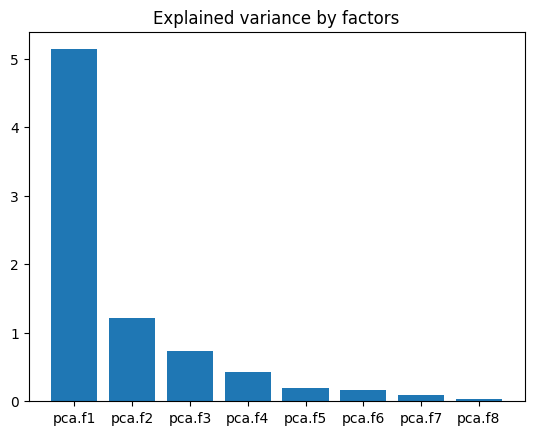

In [174]:
plt.bar(
    x=["pca.f{}".format(i + 1) for i in range(pca.n_components_)],
    height=pca.explained_variance_,
)
plt.title('Explained variance by factors')
plt.show()

##График важности каждой главной компоненты

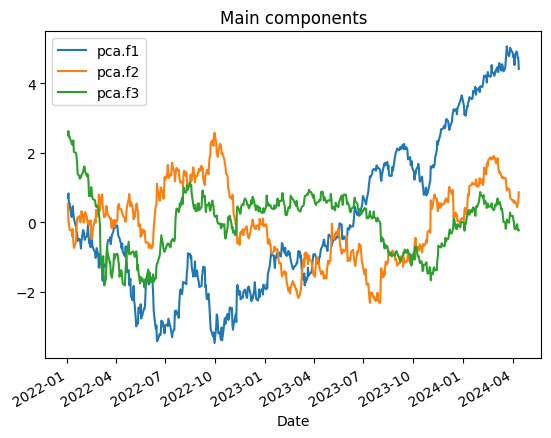

In [175]:
pca_factors = pd.DataFrame(pca.transform(data),
                           columns=['pca.f{}'.format(i+1) for i in range(pca.n_components_)],
                           index=data.index)
pca_factors[['pca.f1', 'pca.f2','pca.f3']].plot()
plt.title("Main components")
plt.show()

##3 главных копоненты и три соответствующих вектора факторных нагрузок

3 главные компоненты: shift,twist,butterfly.

Получим их факторные нагрузки:

PCA loadings: 
         pca.l1    pca.l2    pca.l3
BKNG  0.425061 -0.128121 -0.011924
BKR   0.235463 -0.417586 -0.786005
BLK   0.331957 -0.010913  0.484979
BMY  -0.394967 -0.120987 -0.007758
BR    0.406215  0.216898 -0.031405
BRO   0.402262  0.228456 -0.078832
BSX   0.407909 -0.038479  0.114684
BWA   0.066861 -0.832906  0.355579


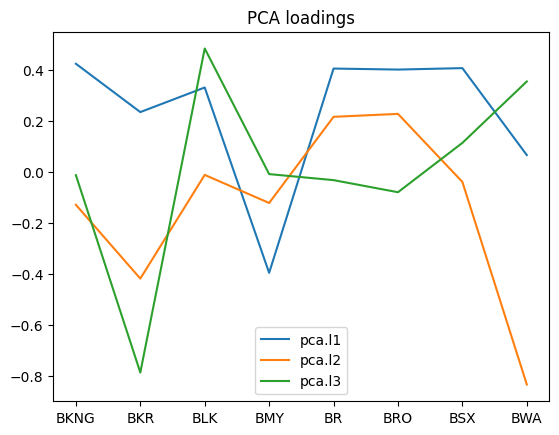

In [176]:
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=["pca.l{}".format(i+1) for i in range(pca.n_components_)],
)
pca_loadings.index = assetList
print('PCA loadings: \n',pca_loadings.iloc[:,0:3])
pca_loadings[['pca.l1', 'pca.l2','pca.l3']].plot()
plt.title("PCA loadings")
plt.show()

и через линейную регрессионную модель:

Loadings by regression: 
         pca.f1    pca.f2    pca.f3
BKNG  0.425061 -0.128121 -0.011924
BKR   0.235463 -0.417586 -0.786005
BLK   0.331957 -0.010913  0.484979
BMY  -0.394967 -0.120987 -0.007758
BR    0.406215  0.216898 -0.031405
BRO   0.402262  0.228456 -0.078832
BSX   0.407909 -0.038479  0.114684
BWA   0.066861 -0.832906  0.355579


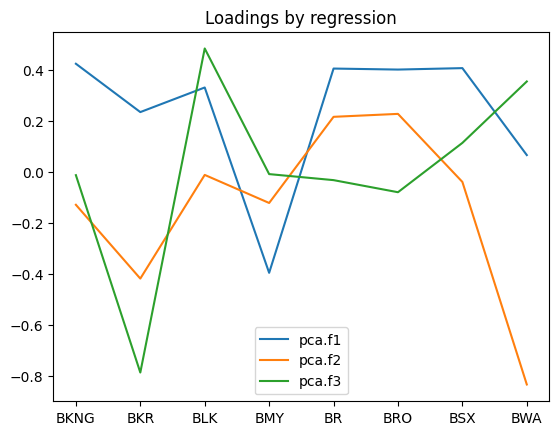

In [177]:
regr = linear_model.LinearRegression()

# Train the models for both factors
reg_l1 = regr.fit(data, pca_factors['pca.f1']).coef_
reg_l2 = regr.fit(data, pca_factors['pca.f2']).coef_
reg_l3 = regr.fit(data, pca_factors['pca.f3']).coef_

loadings_by_regression = pd.DataFrame([reg_l1,reg_l2,reg_l3]).T
loadings_by_regression.index = assetList
loadings_by_regression.columns = ["pca.f1", "pca.f2", "pca.f3"]

print('Loadings by regression: \n', loadings_by_regression)
loadings_by_regression.plot()
plt.title("Loadings by regression")
plt.show()

для справки: получили то же самое

#Автоэнкодер

##Инициализация нейронной сети автоэнкодера с входом из нормированных акций, 3 нейронами на внутренним слое и с выходом, как и размерность входа

In [178]:
encoding_dim = 3
# encode:
input_layer = Input(shape=(data.shape[1],))
encoded_layer = Dense(encoding_dim, use_bias=False, activation=None)
encoded = encoded_layer(input_layer)

# decode:
input_encoded = Input((encoding_dim,))
decoded_layer = Dense(data.shape[1], use_bias=False, activation=None)
decoded = decoded_layer(input_encoded)

# models:
encoder = Model(input_layer, encoded, name="encoder")
decoder = Model(input_encoded, decoded, name="decoder")
autoencoder = Model(input_layer, decoder(encoder(input_layer)), name="autoencoder")

lr = 0.0005 # learning rate, defaults to 0.001
autoencoder.compile(optimizer=Adam(lr), loss='mse')

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8)]               0         
                                                                 
 encoder (Functional)        (None, 3)                 24        
                                                                 
 decoder (Functional)        (None, 8)                 24        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [179]:
autoencoder.fit(data, data,
                verbose=0,
                epochs=6000,
                batch_size=data.shape[0])

In [180]:
encoded_rates = pd.DataFrame(encoder.predict(data), index=data.index, columns=['ae.f1', 'ae.f2','ae.f3'])
encoded_rates.head()

18/18 [==============================] - 0s 1ms/step


,ae.f1,ae.f2,ae.f3
Date,,,
2022-01-03 00:00:00-05:00,-2.310467,-2.206598,-0.160733
2022-01-04 00:00:00-05:00,-2.470663,-2.825577,-0.593117
2022-01-05 00:00:00-05:00,-2.127727,-2.622885,-0.397137
2022-01-06 00:00:00-05:00,-2.183931,-2.827669,-0.547839
2022-01-07 00:00:00-05:00,-2.028833,-2.737539,-0.458435


##Коды 3-х факторов до вращения

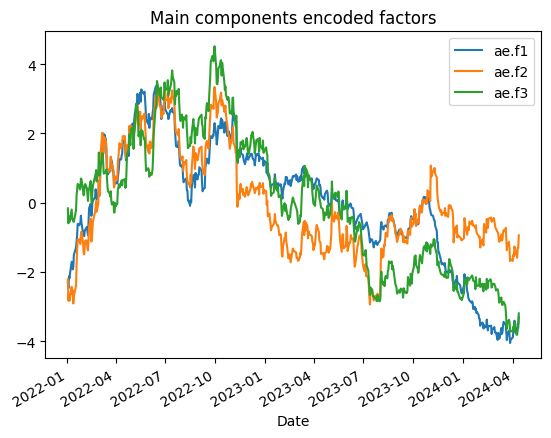

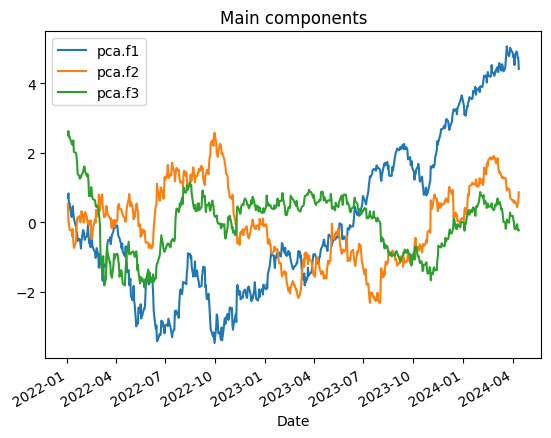

In [181]:
encoded_rates.plot()
plt.title("Main components encoded factors")
plt.show()
pca_factors[['pca.f1', 'pca.f2','pca.f3']].plot()
plt.title("Main components")
plt.show()

Как видим, кодированные основные факторы не похожи на данные от PCA

##3 факторные нагрузки

Autoencoder loadings by regression: 
          ae.f1     ae.f2     ae.f3
BKNG -0.130089  0.074310 -0.247985
BKR   0.338495  0.183219 -0.550448
BLK  -0.573219 -0.572869 -0.251315
BMY   0.437029  0.307327  0.381036
BR   -0.210330  0.210743 -0.115938
BRO  -0.402859 -0.152537 -0.320400
BSX  -0.379665 -0.294921 -0.368048
BWA  -0.265350 -1.111437 -0.602641


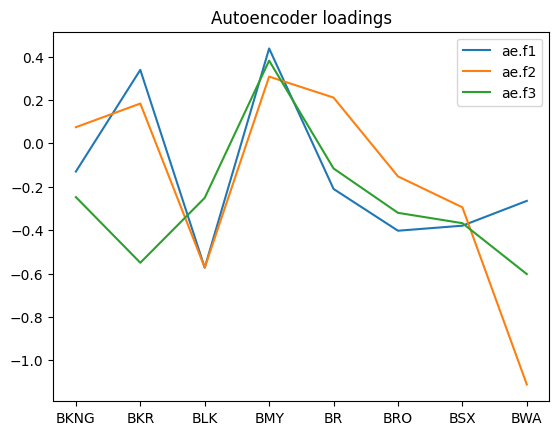

In [182]:
regr = linear_model.LinearRegression()

# Train the models for both factors
rega_l1 = regr.fit(data, encoded_rates['ae.f1']).coef_
rega_l2 = regr.fit(data, encoded_rates['ae.f2']).coef_
rega_l3 = regr.fit(data, encoded_rates['ae.f3']).coef_

ae_loadings = pd.DataFrame([rega_l1,rega_l2,rega_l3]).T
ae_loadings.index = assetList
ae_loadings.columns = ["ae.f1", "ae.f2", "ae.f3"]

print('Autoencoder loadings by regression: \n',ae_loadings)
ae_loadings.plot()
plt.title("Autoencoder loadings")
plt.show()

##Поворот факторов, чтобы они стали некоррелированными
посмотрим корреляцию факторов

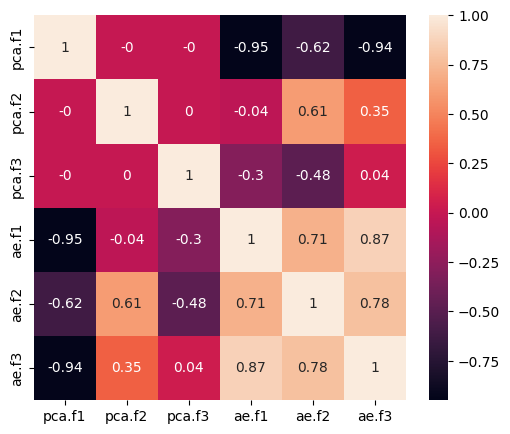

In [183]:
plt.figure(figsize=(6,5))
sns.heatmap(pd.concat([pca_factors[['pca.f1','pca.f2','pca.f3']], encoded_rates], axis=1).corr().round(2), annot=True)
plt.show()

Как видим, главные факторы автоэнкодера коррелированы, в отличии от PCA

##Повернем факторы, чтобы они стали некоррелированными

Для начала получим собственные вектора ковариационной матрицы

In [184]:
eg_vect_factors = np.linalg.eig(encoded_rates.cov())[1]
eg_vect_factors = pd.DataFrame(eg_vect_factors)
eg_vect_factors # matrix of eigenvectors of covariance matrix

,0,1,2
0,-0.587258,-0.618283,0.522354
1,-0.443540,-0.294013,-0.846658
2,-0.677052,0.728892,0.101571


In [185]:
rotated_factors = pd.DataFrame(
    np.dot(encoded_rates,eg_vect_factors),
    columns=['rot.f1','rot.f2','rot.f3'],
    index=data.index
)
rotated_factors.cov().round(2)

,rot.f1,rot.f2,rot.f3
rot.f1,8.38,0.00,-0.00
rot.f2,0.00,0.45,0.00
rot.f3,-0.00,0.00,0.77


Повернули факторы и добились некоррелированности

Следом, выясним, в каком порядке идут факторы PCA относительно факторов автоэнкодера

In [186]:
def defineOrder(pca_factors,rot_factors):
    pca_cols = pca_factors.columns
    rot_cols = rot_factors.columns
    ncol = len(pca_cols)
    mylist = []
    alllist = []
    i = 0

    for pca_col in pca_cols:
        pcaf =pca_factors[pca_col]
        j = 0
        for rot_col in rot_cols:
            rotf = rot_factors[rot_col]
            cor = np.corrcoef(pcaf,rotf)[0,1]
            print(i,j,abs(cor))
            mylist = []
            mylist.append(i)
            mylist.append(j)
            mylist.append(abs(cor))
            mylist.append(np.sign(cor))
            alllist.append(mylist)
            j = j+1
        i = i +1
    df = pd.DataFrame(alllist,columns = ['col1','col2','value','sign'])
    df = df.sort_values(by=['value'], ascending=False)
    df = df[:ncol]
    df = df.sort_values(by='col1')
    return df

In [187]:
norm_factors = pd.DataFrame()

for i in range(3):
    rotated_factors['rot.f'+str(i+1)] = rotated_factors['rot.f'+str(i+1)] / rotated_factors['rot.f'+str(i+1)].std()
    norm_factors['pca.f'+str(i+1)] = pca_factors['pca.f'+str(i+1)] / pca_factors['pca.f'+str(i+1)].std()

orderdf= defineOrder(norm_factors, rotated_factors)
orderdf

0 0 0.9333311314234499
0 1 0.06768753455986809
0 2 0.3520739153927331
1 0 0.2882323372858227
1 1 0.4330402190318323
1 2 0.8511169278611608
2 0 0.20602718517762292
2 1 0.8971663217829344
2 2 0.378773510583878


,col1,col2,value,sign
0,0,0,0.933331,1.0
5,1,2,0.851117,-1.0
7,2,1,0.897166,1.0


Итог аналогичен случаю на лекции:
1. 1-му РСА фактору соответствует и 1-й повернутый от автоэнкодера,умноженный на -1
2. 2-му РСА фактору соответствует 3-й повернутый от автоэнкодера
3. 3-му РСА фактору соответствует 2-й повернутый от автоэнкодера со знаком '-'.



In [188]:
pca_f_plot = pca_factors/pca_factors.std()
rot_f_plot = rotated_factors/rotated_factors.std()

1-е факторы

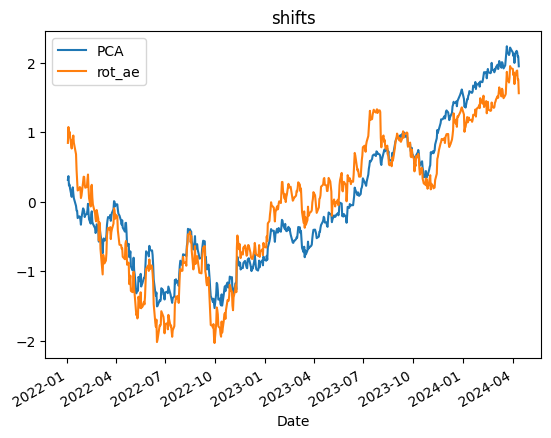

In [192]:
pca_f_plot['pca.f1'].plot()
rot_f_plot['rot.f1'].plot()
plt.title("shifts")
plt.legend(['PCA', 'rot_ae'])
plt.show()

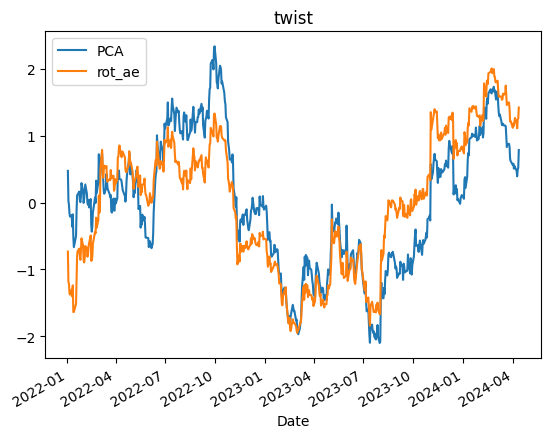

In [193]:
pca_f_plot['pca.f2'].plot()
(-rot_f_plot['rot.f3']).plot()
plt.title("twist")
plt.legend(['PCA', 'rot_ae'])
plt.show()

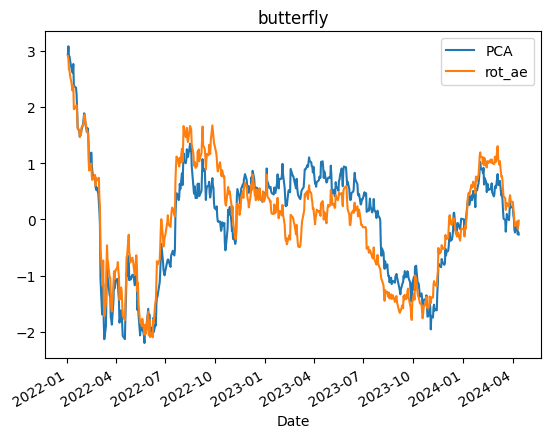

In [194]:
pca_f_plot['pca.f3'].plot()
rot_f_plot['rot.f2'].plot()
plt.title("butterfly")
plt.legend(['PCA', 'rot_ae'])
plt.show()

Получили похожие факторы для всех трех основных факторов, но получается так не всегда, при первой проходке сошлись только первые два.